# Cerinta 1

 Definim un client ca un tuplu fomat din:
 - pozitia de start 
 - pozitia destinatie
 - suma pe care e dispus sa o plateasca 

In [240]:
START = 0
END = 1
BUDGET = 2

In [241]:
def read_file(filename):
    clients = []
    with open(filename, 'r') as reader:
        height, width, capacity = list(map(int, reader.readline().split()))
        carPositionY, carPositionX = list(map(int, reader.readline().split()))
        N = int(reader.readline().split()[0])

        grid = [[0 for j in range(2 * width + 1)] for i in range(height + 2)]
        for i in range(N):
            startY, startX, destinationY, destinationX, budget = list(map(int, reader.readline().split()))
            clients.append(((startY, startX), (destinationY, destinationX), budget))
        for i in range(height + 2):
            line = reader.readline()
            for j in range(2 * width + 1):
                grid[i][j] = line[j]
    return (height, width, capacity, carPositionY, carPositionX, clients, grid)

Definim cele 6 tipuri de actiuni

In [242]:
actions = ["south", "north", "east", "west", "pickup", "dropoff"]
PICKUP = 4
DROPOFF = 5

Definim o actiune aplicata unei stari ca fiind formata dintr-un tuplu:
- tipul de actiune (de lista de mai sus)
- rezultatul actiunii (noua pozitie/ clientul luat/ clientul lasat)

In [243]:
ACTION = 0
RESULT = 1

Functia _getPossibleMoves_ obtine toate mutarile posibile din orice pozitie accesibila (pe care nu se afla un obstacol) (intoarce un dictionar)

In [244]:
def cell_is_free(pos, grid):
    i, j = pos
    if(grid[i][j] == ' ' or grid[i][j] == ':'):
        return True
    return False


def getPossibleMoves(height, width, grid):
    global available_moves
    neighbours = [(1, 0), (-1, 0), (0, 1), (0, -1)]
    for i in range(height):
        for j in range(width):
            pos_in_grid = (i + 1, 2 * j + 1)
            #if the position is free
            if not cell_is_free(pos_in_grid, grid):
                continue
            available_moves[(i,j)] = []
            for n in range(len(neighbours)):
                neigh = neighbours[n]
                pos = tuple(map(lambda x,y: x+y, pos_in_grid, neigh))
                if cell_is_free(pos, grid):
                    available_moves[(i,j)].append((actions[n], tuple(map(lambda x,y: x+y, (i,j), neigh))))
    return available_moves          


Definim starea ca fiind un tuplu format din:
- pozitia curenta a masinii
- lista de clienti ramasi (fara cel aflat deja in masina)
- clientul curent (_None_ daca taxiul e gol)
- capacitatea ramasa a masinii
- suma primita de taxi pana acum

In [245]:
POSITION = 0
CLIENTS = 1
CLIENT = 2
CAPACITY = 3
SUM = 4

In [246]:
#costul pentru a ajunge in starea state este capacitatea consumata (capacity - state[CAPACITY])
#iar efortul scade cu suma incasata (state[SUM])
def cost(state):
    return capacity - state[CAPACITY] - state[SUM]

Functia _get_\__actions_ intoarce toate actiunile ce pot fi aplicate unei stari:
- pozitiile in care poate merge
- clientii pe care ii poate lua
- clientul pe care il poate lasa

In [247]:
def get_actions(state):
    list_actions = list(available_moves[state[POSITION]])
    if state[CLIENT] == None:
        list_actions += list(map(lambda client: (actions[PICKUP], client), \
                 list(filter(lambda client: client[START] == state[POSITION], state[CLIENTS]))))
    elif state[CLIENT][END] == state[POSITION]:
        list_actions.append((actions[DROPOFF], state[CLIENT]))
    return list_actions

Functia _apply_\__action_ aplica o actiune _action_ asupra unei stari _state_ si intoarce o noua stare:
- avand capacitatea decrementata (cu 1l) in cazul in care actiunea este de schimbare a pozitiei
- avand un nou client curent si lista clientilor ramasi actualizata, in cazul in care se ia un client
- neavand niciun client curent si suma acumulata actualizata cu bugetul clientului anterior

In [248]:
def apply_action(state, action):
    if action[ACTION] in actions[0:4]:
        new_state = (action[RESULT], state[CLIENTS], state[CLIENT], state[CAPACITY] - 1, state[SUM])
    elif action[ACTION] == actions[PICKUP]:
        client = action[RESULT]
        clients = tuple(filter(lambda cl: cl != client, state[CLIENTS]))
        new_state = (state[POSITION], clients, client, state[CAPACITY], state[SUM])
    else:
        new_state = (state[POSITION], state[CLIENTS], None, state[CAPACITY], \
                     state[SUM] + state[CLIENT][BUDGET])
    #identify unrealistic states (capacity lower than 0)
    if new_state[CAPACITY] < 0:
        return None 
    
    return new_state

Un nod este compus din:
- stare
- actiunea aplicata de starea parinte pentru a ajunge in noua stare
- adancimea nodului in graf

In [313]:
NODE_STATE = 0
NODE_ACTION = 1
NODE_DEPTH = 2
NODE_FVALUE = 3

class Node:
    def __init__(self, state, action = None, depth = 0, fvalue = 0):
        self.state = state
        self.action = action
        self.depth = depth
        self.fvalue = fvalue
    def __str__(self):
        return (self.state, self.action, self.depth, self.fvalue)
    def __repr__(self):
        return repr((self.state, self.action, self.depth, self.fvalue))

Functia _get_\__successors_ intoarce o lista cu toate nodurile succesoare nodului curent _node_

In [276]:
def get_successors(node):
    state = node.state
    list_actions = get_actions(state)
    #remove unrealistic states identified by None
    succ = list(filter(lambda n: n.state != None, \
            list(map(lambda action: Node(apply_action(state, action), action[ACTION], node.depth + 1),\
            list_actions))))
    return succ

In [277]:
def goal(state):
    return state[CAPACITY] == 0 and state[SUM] > 0

Campurile rezultatului, ce va fi scris in fisierul de output

In [278]:
NR_SCENARIO = 0
STRATEGY = 1
RUNTIME = 2
NO_STATES = 3
COST = 4
ACTIONS = 5

In [279]:
def print_results(results, filename):
    with open(filename, 'w') as writer:
        for result in results:
            writer.write("-" * 30 +"\n")
            for j in range(len(result)):
                writer.write(str(result[j]) + "\n")

# Cerinta 2

## Breadth-first search (BFS)

In [280]:
def print_state(state):
    return str(state[POSITION]) + ", " + str(state[CLIENT]) + ", " + str(state[CAPACITY]) + \
    ", " + str(state[SUM]) + ", " + str(state[CLIENTS])
    
def BreadthFirstSearch(s0):
    parents = {}
    n0 = Node(s0, None, 0)
    OPEN = [n0] #(s0, None) is the first node, from state s0
    parents[n0] = None
    no_visited = 0
    print "s0:"
    print_state(s0)
    while OPEN:
        current = OPEN.pop(0)
        print_state(current.state)
        no_visited += 1
        if goal(current.state):
            return (current, parents, no_visited)
        for succ in get_successors(current):
            parents[succ] = current
            OPEN.append(succ)
    return False


## Uniform cost search

In [284]:
TUPLE_NODE = 0
TUPLE_COST = 1

import bisect
def insert_sorted_by(myState, myList, cost):
    costs = [myTuple[TUPLE_COST] for myTuple in myList]
    index = bisect.bisect(costs, cost)
    myList.insert(index, (myState, cost))

def UniformCostSearch(s0, g):
    parents = {}
    n0 = Node(s0, None, 0)
    OPEN = [(n0, g(s0))] #node (s0, None, 0) with cost g(s0)
    parents[n0] = None
    no_visited = 0
    while OPEN:
        (current, _) = OPEN.pop(0) #first one has the lowest cost
        no_visited += 1
        if goal(current.state):
            return (current, parents, no_visited)
        for succ in get_successors(current):
            parents[succ] = current
            cost = g(succ.state)
            insert_sorted_by(succ, OPEN, cost)
    return False

In [285]:
available_moves = {}
height, width, capacity, carPositionY, carPositionX, clients, grid = read_file(INPUT_PATH + "test3.in")
getPossibleMoves(height, width, grid)
s0 = ((carPositionY, carPositionX), tuple(clients), None, capacity, 0)
UniformCostSearch(s0, cost)

((((3, 4), (((0, 1), (3, 4), 20), ((1, 0), (4, 4), 7), ((0, 2), (4, 3), 16), ((1, 2), (4, 3), 25), ((2, 0), (3, 3), 15), ((3, 3), (4, 0), 8), ((4, 0), (3, 4), 25)), None, 0, 32), 'north', 26, 0),
 {(((2, 0), (((0, 1), (3, 4), 20), ((1, 0), (4, 4), 7), ((0, 2), (4, 3), 16), ((1, 2), (4, 3), 25), ((2, 0), (3, 3), 15), ((3, 3), (4, 0), 8), ((4, 0), (3, 4), 25), ((4, 1), (2, 4), 17)), None, 7, 15), 'west', 17, 0): (((2, 1), (((0, 1), (3, 4), 20), ((1, 0), (4, 4), 7), ((0, 2), (4, 3), 16), ((1, 2), (4, 3), 25), ((2, 0), (3, 3), 15), ((3, 3), (4, 0), 8), ((4, 0), (3, 4), 25), ((4, 1), (2, 4), 17)), None, 8, 15), 'east', 16, 0),
  (((2, 2), (((0, 1), (3, 4), 20), ((1, 0), (4, 4), 7), ((0, 2), (4, 3), 16), ((1, 2), (4, 3), 25), ((2, 0), (3, 3), 15), ((3, 3), (4, 0), 8), ((4, 0), (3, 4), 25)), None, 1, 32), 'west', 25, 0): (((2, 3), (((0, 1), (3, 4), 20), ((1, 0), (4, 4), 7), ((0, 2), (4, 3), 16), ((1, 2), (4, 3), 25), ((2, 0), (3, 3), 15), ((3, 3), (4, 0), 8), ((4, 0), (3, 4), 25)), None, 2, 3

## Depth-first search (DFS)

In [286]:
def DepthFirstSearch(s0):
    parents = {}
    n0 = Node(s0, None, 0)
    OPEN = [n0]
    parents[n0] = None
    no_visited = 0
    while OPEN:
        current = OPEN.pop()
        no_visited += 1
        if goal(current.state):
            return (current, parents, no_visited)
        for succ in get_successors(current):
            parents[succ] = current
            OPEN.append(succ)
    return False


## Depth-limited search

In [287]:
def DepthLimitedSearch(s0, k):
    parents = {}
    n0 = Node(s0, None, 0)
    OPEN = [n0]
    parents[n0] = None
    no_visited = 0
    while OPEN:
        current = OPEN.pop()
        no_visited += 1
        if goal(current.state):
            return (current, parents, no_visited)
        if current.depth >= k:
            continue
        for succ in get_successors(current):
            parents[succ] = current
            OPEN.append(succ)
        
    return False

## Iterative deepening search

In [288]:
def IterativeDeepeningSearch(s0):
    k = 0
    while True:
        result = DepthLimitedSearch(s0, k)
        if result != False:
            return result
        k += 1

# Cerinta 3

_get_\__actions_\__cost_ primeste ca argumente rezultatul furnizat de strategia de cautare si determina un tuplu (secventa de actiuni, cost solutie)

In [289]:
def get_actions_cost(result):
    if result == False:
        return False
    (node, parents, _) = result
    cost = node.state[SUM] + node.state[CAPACITY]
    
    parent_actions = []
    while node.action != None:
        parent_actions = [node.action] + parent_actions
        node = parents[node]
        
    return (parent_actions, cost)

# Cerinta 4

## Greedy Best-first Search

In [290]:
def GreedyBestFirstSearch(s0, h):
    parents = {}
    n0 = Node(s0, None, 0)
    OPEN = [(n0, h(s0))]
    parents[n0] = None
    no_visited = 0
    while OPEN:
        (current, _) = OPEN.pop(0) #first one has the lowest cost
        no_visited += 1
        if goal(current.state):
            return (current, parents, no_visited)
        for succ in get_successors(current):
            parents[succ] = current
            cost = h(succ.state)
            insert_sorted_by(succ, OPEN, cost)
    return False

## A* search
Dupa modul in care am definit starea = (pozitie masina, capacitate ramasa, suma acumulata), aceeasi stare va avea intotdeauna acelasi cost (capacitate consumata - suma acumulata), deci nu mai este nevoie sa verific: _g(succ) < g(current)_ (vor fi mereu egale).

In [291]:
def AStarSearch(state, g, h):
    parents = {}
    n0 = Node(s0, None, 0)
    OPEN = [(n0, g(s0))]
    parents[n0] = None
    CLOSED = {}
    no_visited = 0
    while OPEN:
        (current, crt_cost) = OPEN.pop(0)
        no_visited += 1
        if goal(current.state):
            return (current, parents, no_visited)
        CLOSED[current.state] = current
        for succ in get_successors(current):
            cost = h(succ.state) + g(succ.state)      
            #elimin starea din OPEN, daca exista, apoi actualizez parintele si pun noul nod in OPEN
            OPEN = list(filter(lambda x: x.state != succ.state, OPEN))  
            #elimin starea din closed, daca o gasesc
            if succ.state in CLOSED:
                CLOSED.pop(succ.state)
            #actualizez parintele si pun noul nod in OPEN
            parents[succ] = current
            insert_sorted_by(succ, OPEN, cost)
    return False        

## Hill-climbing search
Aleg castigul starii _state_ ca fiind: _state[SUM] - (capacity - state[CAPACITY])_ (suma primita pana in acea stare - litrii consumati)

In [292]:
from math import fabs

eps = 0.00001

def manhattan_distance(client):
    return fabs(client[START][0] - client[END][0]) + fabs(client[START][1] - client[END][1])

#va minimiza distanta manhattan pana la destinatie daca taxiul are client
def reward(node):
    #in starea intiala se porneste de la 0
    if(node.action == None):
        return 0
    h = 0
    #la DROP_OFF consider castigul facut la pasul anterior (g), putin mai mare (+eps), pentru a putea continua alg
    if node.action == actions[DROPOFF]:
        return eps      
    if node.state[CLIENT] == None:    
        #numarul de mutari neceasre pentru a lua cel mai avantajos client si al duce la destinatie
        #(1 e pentru mutarea dinainte, prin care se ajunge in nod)
        get_needed_distance = lambda client: \
            manhattan_distance((node.state[POSITION], client[START])) + manhattan_distance(client) + 1
        get_heuristic = lambda client: 0 if get_needed_distance(client) > node.state[CAPACITY] else\
            client[BUDGET] / get_needed_distance(client)
        h += max([get_heuristic(client) for client in node.state[CLIENTS]])        
    else:
        dist = 0
        #la pick_up consider castigul din primul pas (dist += 1), putin mai mic (cu eps), pentru a putea face apoi primul pas
        if node.action == actions[PICKUP]:
            h -= eps
            dist += 1
        client = node.state[CLIENT]
        car_to_dest = (node.state[POSITION], client[END])
        dist += manhattan_distance(car_to_dest) + 1
        h += 0 if dist > node.state[CAPACITY] else client[BUDGET] / dist
    return h

def HillClimbingSearch(s0, g, h):
    parents = {}
    n0 = Node(s0, None, 0)
    parents[n0] = None
    done = False
    current = n0
    current_cost = g(current.state) + h(current)
    no_visited = 0
    while done == False:
        no_visited += 1
        maxim = current_cost
        next_state = None
        for succ in get_successors(current):
            cost = g(succ.state) + h(succ)
            if cost > maxim:
                maxim = cost
                next_state = succ
        if next_state == None:
            done = True
        else:
            parents[next_state] = current
            current = next_state
            current_cost = maxim
    return (current, parents, no_visited)

# Cerinta 5

# Prevenirea revizitarii unei stari

## Breadth-first search (BFS)

In [293]:
def BreadthFirstSearchOpt(s0):
    parents = {}
    n0 = Node(s0, None, 0)#(s0, None) is the first node, from state s0
    OPEN = [n0] 
    parents[n0] = None
    visited = set()
    visited.add(s0)
    while OPEN:
        current = OPEN.pop(0)
        if goal(current.state):
            return (current, parents, len(visited) + 1)
        for succ in get_successors(current):
            if succ.state in visited:
                continue
            visited.add(succ.state)
            parents[succ] = current
            OPEN.append(succ)
    return False

In [294]:
available_moves = {}
height, width, capacity, carPositionY, carPositionX, clients, grid = read_file(INPUT_PATH + "test4.in")
getPossibleMoves(height, width, grid)
s0 = ((carPositionY, carPositionX), tuple(clients), None, capacity, 0)
BreadthFirstSearchOpt(s0)

((((1, 5), (((0, 6), (3, 2), 5), ((1, 0), (4, 6), 20), ((1, 2), (4, 3), 25), ((2, 0), (3, 3), 15), ((1, 5), (3, 4), 25), ((5, 1), (2, 4), 17)), None, 0, 7), 'dropoff', 22, 0),
 {(((6, 0), (((0, 6), (3, 2), 5), ((2, 4), (1, 5), 7), ((1, 0), (4, 6), 20), ((1, 2), (4, 3), 25), ((2, 0), (3, 3), 15), ((5, 1), (2, 4), 17)), ((1, 5), (3, 4), 25), 10, 0), 'west', 11, 0): (((6, 1), (((0, 6), (3, 2), 5), ((2, 4), (1, 5), 7), ((1, 0), (4, 6), 20), ((1, 2), (4, 3), 25), ((2, 0), (3, 3), 15), ((5, 1), (2, 4), 17)), ((1, 5), (3, 4), 25), 11, 0), 'west', 10, 0),
  (((5, 3), (((2, 4), (1, 5), 7), ((1, 0), (4, 6), 20), ((1, 2), (4, 3), 25), ((2, 0), (3, 3), 15), ((1, 5), (3, 4), 25), ((5, 1), (2, 4), 17)), None, 0, 5), 'east', 22, 0): (((5, 2), (((2, 4), (1, 5), 7), ((1, 0), (4, 6), 20), ((1, 2), (4, 3), 25), ((2, 0), (3, 3), 15), ((1, 5), (3, 4), 25), ((5, 1), (2, 4), 17)), None, 1, 5), 'south', 21, 0),
  (((5, 3), (((0, 6), (3, 2), 5), ((2, 4), (1, 5), 7), ((1, 0), (4, 6), 20), ((1, 2), (4, 3), 25), 

## Uniform Cost Search

In [295]:
def UniformCostSearchOpt(s0, g):
    parents = {}
    n0 = Node(s0, None, 0)
    OPEN = [(n0, g(s0))] #node Node(s0, None, 0) with cost g(s0)
    parents[n0] = None
    visited = set()
    visited.add(s0)
    while OPEN:
        (current, _) = OPEN.pop(0) #first one has the lowest cost
        if goal(current.state):
            return (current, parents, len(visited) + 1)
        for succ in get_successors(current):
            if succ.state in visited:
                continue
            visited.add(succ.state)
            parents[succ] = current
            cost = g(succ.state)
            insert_sorted_by(succ, OPEN, cost)
    return False

In [296]:
available_moves = {}
height, width, capacity, carPositionY, carPositionX, clients, grid = read_file(INPUT_PATH + "test3.in")
getPossibleMoves(height, width, grid)
s0 = ((carPositionY, carPositionX), tuple(clients), None, capacity, 0)
UniformCostSearchOpt(s0, cost)

((((3, 4), (((0, 1), (3, 4), 20), ((1, 0), (4, 4), 7), ((0, 2), (4, 3), 16), ((1, 2), (4, 3), 25), ((2, 0), (3, 3), 15), ((3, 3), (4, 0), 8), ((4, 0), (3, 4), 25)), None, 0, 32), 'north', 26, 0),
 {(((2, 0), (((2, 2), (4, 2), 5), ((0, 1), (3, 4), 20), ((1, 0), (4, 4), 7), ((0, 2), (4, 3), 16), ((1, 2), (4, 3), 25), ((2, 0), (3, 3), 15), ((3, 3), (4, 0), 8), ((4, 0), (3, 4), 25), ((4, 1), (2, 4), 17)), ((1, 1), (3, 2), 10), 17, 0), 'west', 4, 0): (((2, 1), (((2, 2), (4, 2), 5), ((0, 1), (3, 4), 20), ((1, 0), (4, 4), 7), ((0, 2), (4, 3), 16), ((1, 2), (4, 3), 25), ((2, 0), (3, 3), 15), ((3, 3), (4, 0), 8), ((4, 0), (3, 4), 25), ((4, 1), (2, 4), 17)), ((1, 1), (3, 2), 10), 18, 0), 'south', 3, 0),
  (((1, 3), (((2, 2), (4, 2), 5), ((0, 1), (3, 4), 20), ((1, 0), (4, 4), 7), ((0, 2), (4, 3), 16), ((1, 2), (4, 3), 25), ((2, 0), (3, 3), 15), ((3, 3), (4, 0), 8), ((4, 0), (3, 4), 25), ((4, 1), (2, 4), 17)), ((1, 1), (3, 2), 10), 17, 0), 'east', 4, 0): (((1, 2), (((2, 2), (4, 2), 5), ((0, 1), (3

## Depth-first search (DFS)

In [297]:
def DepthFirstSearchOpt(s0):
    parents = {}
    n0 = Node(s0, None, 0)
    OPEN = [n0]
    parents[n0] = None
    visited = set()
    visited.add(s0)
    while OPEN:
        current = OPEN.pop()
        if goal(current.state):
            return (current, parents, len(visited) + 1)
        for succ in get_successors(current):
            if succ.state in visited:
                continue
            visited.add(succ.state)
            parents[succ] = current
            OPEN.append(succ)
    return False

In [298]:
available_moves = {}
height, width, capacity, carPositionY, carPositionX, clients, grid = read_file(INPUT_PATH + "test3.in")
getPossibleMoves(height, width, grid)
s0 = ((carPositionY, carPositionX), tuple(clients), None, capacity, 0)
DepthFirstSearchOpt(s0)

((((3, 4), (((1, 1), (3, 2), 10), ((2, 2), (4, 2), 5), ((0, 1), (3, 4), 20), ((1, 0), (4, 4), 7), ((0, 2), (4, 3), 16), ((1, 2), (4, 3), 25), ((4, 0), (3, 4), 25), ((4, 1), (2, 4), 17)), ((3, 3), (4, 0), 8), 0, 15), 'east', 23, 0),
 {(((2, 0), (((1, 1), (3, 2), 10), ((2, 2), (4, 2), 5), ((0, 1), (3, 4), 20), ((1, 0), (4, 4), 7), ((0, 2), (4, 3), 16), ((1, 2), (4, 3), 25), ((2, 0), (3, 3), 15), ((3, 3), (4, 0), 8), ((4, 0), (3, 4), 25), ((4, 1), (2, 4), 17)), None, 19, 0), 'west', 1, 0): (((2, 1), (((1, 1), (3, 2), 10), ((2, 2), (4, 2), 5), ((0, 1), (3, 4), 20), ((1, 0), (4, 4), 7), ((0, 2), (4, 3), 16), ((1, 2), (4, 3), 25), ((2, 0), (3, 3), 15), ((3, 3), (4, 0), 8), ((4, 0), (3, 4), 25), ((4, 1), (2, 4), 17)), None, 20, 0), None, 0, 0),
  (((2, 1), (((1, 1), (3, 2), 10), ((2, 2), (4, 2), 5), ((0, 1), (3, 4), 20), ((1, 0), (4, 4), 7), ((0, 2), (4, 3), 16), ((1, 2), (4, 3), 25), ((2, 0), (3, 3), 15), ((3, 3), (4, 0), 8), ((4, 0), (3, 4), 25), ((4, 1), (2, 4), 17)), None, 20, 0), None, 0

## Depth-limited search

In [299]:
def DepthLimitedSearchOpt(s0, k):
    parents = {}
    n0 = Node(s0, None, 0)
    OPEN = [n0]
    parents[n0] = None
    visited = set()
    visited.add(s0)
    while OPEN:
        current = OPEN.pop()
        if goal(current.state):
            return (current, parents, len(visited) + 1)
        if current.depth >= k:
            continue
        for succ in get_successors(current):
            if succ.state in visited:
                continue
            visited.add(succ.state)
            parents[succ] = current
            OPEN.append(succ)
        
    return False

In [300]:
available_moves = {}
height, width, capacity, carPositionY, carPositionX, clients, grid = read_file(INPUT_PATH + "test2.in")
getPossibleMoves(height, width, grid)
s0 = ((carPositionY, carPositionX), tuple(clients), None, capacity, 0)
DepthLimitedSearchOpt(s0, 30)

((((3, 3), (((1, 1), (3, 2), 10), ((2, 2), (4, 2), 5), ((0, 1), (3, 4), 20), ((1, 0), (4, 4), 7), ((0, 2), (4, 3), 16), ((1, 2), (4, 3), 25), ((3, 3), (4, 0), 8), ((4, 0), (3, 4), 25), ((4, 1), (2, 4), 17)), None, 0, 15), 'dropoff', 17, 0),
 {(((2, 1), (((1, 1), (3, 2), 10), ((2, 2), (4, 2), 5), ((0, 1), (3, 4), 20), ((1, 0), (4, 4), 7), ((0, 2), (4, 3), 16), ((1, 2), (4, 3), 25), ((2, 0), (3, 3), 15), ((3, 3), (4, 0), 8), ((4, 0), (3, 4), 25), ((4, 1), (2, 4), 17)), None, 15, 0), None, 0, 0): None,
  (((3, 1), (((1, 1), (3, 2), 10), ((2, 2), (4, 2), 5), ((0, 1), (3, 4), 20), ((1, 0), (4, 4), 7), ((0, 2), (4, 3), 16), ((1, 2), (4, 3), 25), ((2, 0), (3, 3), 15), ((3, 3), (4, 0), 8), ((4, 0), (3, 4), 25), ((4, 1), (2, 4), 17)), None, 14, 0), 'south', 1, 0): (((2, 1), (((1, 1), (3, 2), 10), ((2, 2), (4, 2), 5), ((0, 1), (3, 4), 20), ((1, 0), (4, 4), 7), ((0, 2), (4, 3), 16), ((1, 2), (4, 3), 25), ((2, 0), (3, 3), 15), ((3, 3), (4, 0), 8), ((4, 0), (3, 4), 25), ((4, 1), (2, 4), 17)), None,

## Iterative deepening search

In [301]:
def IterativeDeepeningSearchOpt(s0):
    k = 0
    while True:
        result = DepthLimitedSearchOpt(s0, k)
        if result != False:
            return result
        k += 1

## Greedy Best-first Search

In [302]:
def GreedyBestFirstSearchOpt(s0, h):
    parents = {}
    n0 = Node(s0, None, 0)
    OPEN = [(n0, h(s0))]
    parents[n0] = None
    visited = set()
    visited.add(s0)
    while OPEN:
        (current, _) = OPEN.pop(0) #first one has the lowest cost
        if goal(current.state):
            return (current, parents,len(visited) + 1)
        for succ in get_successors(current):
            if succ.state in visited:
                continue
            visited.add(succ.state)
            parents[succ] = current
            cost = h(succ.state)
            insert_sorted_by(succ, OPEN, cost)
    return False

In [341]:
available_moves = {}
height, width, capacity, carPositionY, carPositionX, clients, grid = read_file(INPUT_PATH + "test6.in")
getPossibleMoves(height, width, grid)
s0 = ((carPositionY, carPositionX), tuple(clients), None, capacity, 0)
GreedyBestFirstSearchOpt(s0, h1)

((((9, 5), (((0, 6), (3, 2), 5), ((1, 8), (4, 6), 20), ((2, 3), (1, 2), 15), ((1, 2), (4, 3), 25), ((2, 0), (8, 3), 15), ((9, 5), (9, 4), 25), ((5, 1), (7, 4), 17), ((1, 2), (3, 6), 23), ((0, 6), (6, 0), 28)), None, 0, 7), 'south', 27, 0),
 {(((8, 7), (((0, 6), (3, 2), 5), ((2, 4), (1, 5), 7), ((2, 3), (1, 2), 15), ((1, 2), (4, 3), 25), ((2, 0), (8, 3), 15), ((9, 5), (9, 4), 25), ((5, 1), (7, 4), 17), ((1, 2), (3, 6), 23), ((0, 6), (6, 0), 28)), ((1, 8), (4, 6), 20), 7, 0), 'west', 19, 0): (((8, 8), (((0, 6), (3, 2), 5), ((2, 4), (1, 5), 7), ((2, 3), (1, 2), 15), ((1, 2), (4, 3), 25), ((2, 0), (8, 3), 15), ((9, 5), (9, 4), 25), ((5, 1), (7, 4), 17), ((1, 2), (3, 6), 23), ((0, 6), (6, 0), 28)), ((1, 8), (4, 6), 20), 8, 0), 'south', 18, 0),
  (((9, 0), (((0, 6), (3, 2), 5), ((2, 4), (1, 5), 7), ((1, 8), (4, 6), 20), ((2, 3), (1, 2), 15), ((1, 2), (4, 3), 25), ((2, 0), (8, 3), 15), ((9, 5), (9, 4), 25), ((5, 1), (7, 4), 17), ((1, 2), (3, 6), 23), ((0, 6), (6, 0), 28)), None, 7, 0), 'west'

## A* search

In [306]:
def AStarSearchOpt(s0, g, h):
    parents = {}
    n0 = Node(s0, None, 0)
    OPEN = [(n0, g(s0))]
    parents[n0] = None
    CLOSED = {}
    visited = set()
    visited.add(s0)
    while OPEN:
        (current, crt_cost) = OPEN.pop(0)
        if goal(current.state):
            return (current, parents, len(visited) + 1)
        
        CLOSED[current.state] = current
        for succ in get_successors(current):
            if succ.state in visited:
                continue
            visited.add(succ.state)
            cost = h(succ.state) + g(succ.state)      
            #elimin starea din OPEN, daca exista, apoi actualizez parintele si pun noul nod in OPEN
            OPEN = list(filter(lambda (x, _): x.state != succ.state, OPEN))  
            #elimin starea din closed, daca o gasesc
            if succ.state in CLOSED:
                CLOSED.pop(succ.state)
            #actualizez parintele si pun noul nod in OPEN
            parents[succ] = current
            insert_sorted_by(succ, OPEN, cost)
    return False

In [307]:
available_moves = {}
height, width, capacity, carPositionY, carPositionX, clients, grid = read_file(INPUT_PATH + "test4.in")
getPossibleMoves(height, width, grid)
s0 = ((carPositionY, carPositionX), tuple(clients), None, capacity, 0)
AStarSearchOpt(s0, cost, h1)

((((3, 5), (((0, 6), (3, 2), 5), ((1, 0), (4, 6), 20), ((2, 0), (3, 3), 15), ((5, 1), (2, 4), 17)), None, 0, 57), 'south', 26, 0),
 {(((4, 6), (((1, 0), (4, 6), 20), ((1, 2), (4, 3), 25), ((2, 0), (3, 3), 15), ((5, 1), (2, 4), 17)), ((0, 6), (3, 2), 5), 8, 32), 'south', 17, 0): (((3, 6), (((1, 0), (4, 6), 20), ((1, 2), (4, 3), 25), ((2, 0), (3, 3), 15), ((5, 1), (2, 4), 17)), ((0, 6), (3, 2), 5), 9, 32), 'south', 16, 0),
  (((2, 3), (((0, 6), (3, 2), 5), ((2, 4), (1, 5), 7), ((1, 0), (4, 6), 20), ((1, 2), (4, 3), 25), ((5, 1), (2, 4), 17)), ((2, 0), (3, 3), 15), 9, 25), 'east', 14, 0): (((2, 2), (((0, 6), (3, 2), 5), ((2, 4), (1, 5), 7), ((1, 0), (4, 6), 20), ((1, 2), (4, 3), 25), ((5, 1), (2, 4), 17)), ((2, 0), (3, 3), 15), 10, 25), 'east', 13, 0),
  (((4, 5), (((0, 6), (3, 2), 5), ((2, 4), (1, 5), 7), ((1, 0), (4, 6), 20), ((2, 0), (3, 3), 15), ((5, 1), (2, 4), 17)), ((1, 2), (4, 3), 25), 7, 25), 'east', 16, 0): (((4, 4), (((0, 6), (3, 2), 5), ((2, 4), (1, 5), 7), ((1, 0), (4, 6), 20

## Hill-climbing search

In [308]:
def HillClimbingSearchOpt(s0, g, h):
    parents = {}
    n0 = Node(s0, None, 0)
    parents[n0] = None
    done = False
    current = n0
    current_cost = g(current.state) + h(current)
    visited = set()
    visited.add(n0)
    while done == False:
        maxim = current_cost
        next_state = None
        for succ in get_successors(current):
            if succ.state in visited:
                continue
            visited.add(succ.state)
            cost = g(succ.state) + h(succ)
            if cost > maxim:
                maxim = cost
                next_state = succ
        if next_state == None:
            done = True
        else:
            parents[next_state] = current
            current = next_state
            current_cost = maxim
    return (current, parents, len(visited))

## Recursive Best-First Search

Am folosit campul NODE_FVALUE al unui nod drept costul total f pana la o solutie

In [342]:
def RBFS(node, limit, parents, visited, g, h):
    visited.add(node)
    
    if goal(node.state):
        return ((node, parents, len(visited)), limit)

    list_succ = get_successors(node)
    if len(list_succ) == 0:
        return (False, float("inf"))
    for succ in list_succ:
        #revisit the lost subtrees
        succ.fvalue = max([g(succ.state) + h(succ.state), node.fvalue])
        parents[succ] = node
    
    while True:
        #get node with lowest f-value 
        best = reduce(lambda bestNode, node: (bestNode if bestNode.fvalue < \
                      node.fvalue else node), list_succ)
        #if it is above the limit (second lowest f-value) it unwinds to that node
        if best.fvalue > limit:
            return (False, best.fvalue)
        #find the second lowest f-value between node successors
        second = max(list(filter(lambda x: x != best.fvalue, \
                [succ.fvalue for succ in list_succ])) + [0])
        #go to best and set the limit to second if lower than the limit
        #set the best f-value to its successor to continue to unwind to other node
        #in the next iteration
        result, best.fvalue = RBFS(best, min(limit, second), parents, visited, g, h)
        if result:
            return (result, best.fvalue)
    return False

def RecursiveBestFirstSearch(s0, g, h):
    parents = {}
    n0 = Node(s0)
    parents[n0] = None
    sol, _ = RBFS(n0, float("inf"), parents, set(), g, h)
    return sol


In [343]:
available_moves = {}
height, width, capacity, carPositionY, carPositionX, clients, grid = read_file(INPUT_PATH + "test6.in")
getPossibleMoves(height, width, grid)
s0 = ((carPositionY, carPositionX), tuple(clients), None, capacity, 0)
RecursiveBestFirstSearch(s0, cost, h1)

((((1, 1), (((0, 6), (3, 2), 5), ((2, 4), (1, 5), 7), ((1, 2), (4, 3), 25), ((2, 0), (8, 3), 15), ((9, 5), (9, 4), 25), ((5, 1), (7, 4), 17), ((0, 6), (6, 0), 28)), ((1, 2), (3, 6), 23), 0, 35), 'west', 30, 0),
 {(((6, 6), (((0, 6), (3, 2), 5), ((2, 4), (1, 5), 7), ((2, 3), (1, 2), 15), ((1, 2), (4, 3), 25), ((2, 0), (8, 3), 15), ((9, 5), (9, 4), 25), ((5, 1), (7, 4), 17), ((1, 2), (3, 6), 23), ((0, 6), (6, 0), 28)), ((1, 8), (4, 6), 20), 0, 0), 'west', 26, 25.0): (((6, 7), (((0, 6), (3, 2), 5), ((2, 4), (1, 5), 7), ((2, 3), (1, 2), 15), ((1, 2), (4, 3), 25), ((2, 0), (8, 3), 15), ((9, 5), (9, 4), 25), ((5, 1), (7, 4), 17), ((1, 2), (3, 6), 23), ((0, 6), (6, 0), 28)), ((1, 8), (4, 6), 20), 1, 0), 'south', 25, 25.0),
  (((0, 7), (((0, 6), (3, 2), 5), ((2, 4), (1, 5), 7), ((2, 3), (1, 2), 15), ((1, 2), (4, 3), 25), ((2, 0), (8, 3), 15), ((9, 5), (9, 4), 25), ((5, 1), (7, 4), 17), ((1, 2), (3, 6), 23), ((0, 6), (6, 0), 28)), ((1, 8), (4, 6), 20), 1, 0), 'west', 25, 25.0): (((0, 8), (((0, 

## Learning Real-Time A*

In [433]:
LRTA_Cost = lambda parent, succ, Rezultat, H, g, h: \
    g(succ.state) - g(parent.state) + H[succ.state] if \
    ((parent.state, succ.action) in Rezultat) else h(parent.state)

def LearningRealTimeAStar(current, visited, parents, H, g, h, Rezultat):
    if goal(current.state):
        return (current, parents, len(visited))
    if current.state not in H:
        H[current.state] = h(current.state)
    parent = parents[current]
    if parent != None:
        Rezultat[(parent.state, current.action)] = current
        list_succ = get_successors(parent)
        #dupa ce vizitez o stare actualizez estimarea parintelui
        H[parent] = min([LRTA_Cost(parent, succ, Rezultat, H, g, h) for succ in list_succ])
        
    list_succ = []
    for succ in get_successors(current):
        if succ.state in visited:
            continue
        list_succ.append(succ)
        visited.add(succ.state)
        parents[succ] = current
    #selectez nodul aparent cel mai bun (cautare locala)

    for _ in range(len(list_succ)):
        a = reduce(lambda val, succ: \
               (val if LRTA_Cost(current, val, Rezultat, H, g, h) > LRTA_Cost(current, succ, Rezultat, H, g, h) \
               else succ), list_succ )
        sol = LearningRealTimeAStar(a, visited, parents, H, g, h, Rezultat)
        if sol:
            return sol
        list_succ.remove(a)
    return False

In [438]:
available_moves = {}
height, width, capacity, carPositionY, carPositionX, clients, grid = read_file(INPUT_PATH + "test6.in")
getPossibleMoves(height, width, grid)
s0 = ((carPositionY, carPositionX), tuple(clients), None, capacity, 0)
n0 = Node(s0)
LearningRealTimeAStar(n0, set(s0), {n0:None}, {}, cost, h2, {})

((((4, 6), (((0, 6), (3, 2), 5), ((2, 4), (1, 5), 7), ((2, 3), (1, 2), 15), ((1, 2), (4, 3), 25), ((2, 0), (8, 3), 15), ((9, 5), (9, 4), 25), ((5, 1), (7, 4), 17), ((1, 2), (3, 6), 23), ((0, 6), (6, 0), 28)), None, 0, 20), 'dropoff', 27, 0),
 {(((2, 7), (((0, 6), (3, 2), 5), ((2, 4), (1, 5), 7), ((2, 3), (1, 2), 15), ((1, 2), (4, 3), 25), ((2, 0), (8, 3), 15), ((9, 5), (9, 4), 25), ((5, 1), (7, 4), 17), ((1, 2), (3, 6), 23), ((0, 6), (6, 0), 28)), ((1, 8), (4, 6), 20), 1, 0), 'south', 25, 0): (((1, 7), (((0, 6), (3, 2), 5), ((2, 4), (1, 5), 7), ((2, 3), (1, 2), 15), ((1, 2), (4, 3), 25), ((2, 0), (8, 3), 15), ((9, 5), (9, 4), 25), ((5, 1), (7, 4), 17), ((1, 2), (3, 6), 23), ((0, 6), (6, 0), 28)), ((1, 8), (4, 6), 20), 2, 0), 'west', 24, 0),
  (((1, 7), (((0, 6), (3, 2), 5), ((2, 4), (1, 5), 7), ((1, 8), (4, 6), 20), ((2, 3), (1, 2), 15), ((1, 2), (4, 3), 25), ((2, 0), (8, 3), 15), ((9, 5), (9, 4), 25), ((5, 1), (7, 4), 17), ((1, 2), (3, 6), 23), ((0, 6), (6, 0), 28)), None, 22, 0), 'we

# Cerinta 6

In [445]:
import time
import os
INPUT_PATH = "./Teste/"
OUTPUT_PATH = "./Outputs/"

def get_results_alg(all_alg, all_args, all_tags, results, nr_test):
    for i in range(len(all_alg)):
        start = time.time()
        res = all_alg[i](*all_args[i])
        end = time.time()
        elapsed_time = end - start
    
        node, parents, no_visited = res
        actions, cost = get_actions_cost(res)
        results[all_tags[i]].append((nr_test, \
                all_tags[i], elapsed_time, no_visited, cost, actions))

def h1(state):
    rest_of_sum = reduce(lambda my_sum, client: my_sum + client[BUDGET], state[CLIENTS], 0)
    return max([state[CAPACITY] + state[SUM] - rest_of_sum, 0]) if state[CAPACITY] > 0 else 0

def h2(state):
    if state[CLIENT] == None:    
        get_needed_distance = lambda client: \
            manhattan_distance((state[POSITION], client[START])) + manhattan_distance(client)
        get_heuristic = lambda client: 0 if get_needed_distance(client) > state[CAPACITY] else\
            get_needed_distance(client) - client[BUDGET]
        h = min([get_heuristic(client) for client in state[CLIENTS]])        
    else:      
        client = state[CLIENT]
        dist = manhattan_distance((state[POSITION], client[END]))
        h = 0 if dist > state[CAPACITY] else dist - client[BUDGET]
    return h

all_unopt_alg = [BreadthFirstSearch, UniformCostSearch, DepthFirstSearch, DepthLimitedSearch, \
        IterativeDeepeningSearch, GreedyBestFirstSearch, AStarSearch, HillClimbingSearch, \
        GreedyBestFirstSearch, AStarSearch]
all_unopt_tags = ["BreadthFirstSearch", "UniformCostSearch", "DepthFirstSearch", "DepthLimitedSearch", \
       "IterativeDeepeningSearch", "GreedyBestFirstSearchH1", "AStarSearchH1", "HillClimbingSearch", \
        "GreedyBestFirstSearchH2", "AStarSearchH2"]
all_opt_alg = [BreadthFirstSearchOpt, UniformCostSearchOpt, DepthFirstSearchOpt, DepthLimitedSearchOpt, \
       IterativeDeepeningSearchOpt, GreedyBestFirstSearchOpt, AStarSearchOpt, HillClimbingSearchOpt, \
        GreedyBestFirstSearchOpt, AStarSearchOpt, RecursiveBestFirstSearch, LearningRealTimeAStar]
all_opt_tags = ["BreadthFirstSearchOpt", "UniformCostSearchOpt", "DepthFirstSearchOpt", "DepthLimitedSearchOpt", \
       "IterativeDeepeningSearchOpt", "GreedyBestFirstSearchOptH1", "AStarSearchOptH1", \
        "HillClimbingSearchOpt", "GreedyBestFirstSearchOptH2", "AStarSearchOptH2", \
        "RecursiveBestFirstSearchH2", "LearningRealTimeAStarH2"]

all_tags = all_opt_tags
results_alg = {alg_tag : [] for alg_tag in all_tags}
for filename in os.listdir(INPUT_PATH):
    print filename
    available_moves = {}
    height, width, capacity, carPositionY, carPositionX, clients, grid = read_file(INPUT_PATH + filename)
    getPossibleMoves(height, width, grid)
    s0 = ((carPositionY, carPositionX), tuple(clients), None, capacity, 0, None)
    
    h = [h1, h2]
    NEG, POS = 0, 1
    g = [cost, lambda state: -cost(state)]
    n0 = Node(s0)
    all_args = [(s0,), (s0, cost), (s0,), (s0, 30), (s0,), (s0, h[0]), (s0, g[NEG], h[0]), (s0, g[POS], reward), \
               (s0, h[1]), (s0, g[NEG], h[1]), (s0, g[NEG], h[1]), (n0, set(s0), {n0:None}, {}, g[NEG], h[1], {})]
    
    #results_unopt = get_results_alg(all_unopt_alg, all_args, all_unopt_tags)
    #print_results(results_unopt, OUTPUT_PATH + filename[-3] + ".out")
    
    get_results_alg(all_opt_alg, all_args, all_opt_tags, results_alg, int(filename[-4]))

test3.in
test2.in
test4.in
test1.in
test5.in
test6.in


In [446]:
#sortez dupa numarul de teste
for tag in results_alg:
    results_alg[tag].sort(key = lambda x: x[0])
print results_alg["BreadthFirstSearchOpt"]
for tag in all_tags:
    print_results(results_alg[tag], OUTPUT_PATH + tag + ".out")


[(1, 'BreadthFirstSearchOpt', 0.0009508132934570312, 144, 5, ['south', 'north', 'pickup', 'south', 'south', 'dropoff', 'north']), (2, 'BreadthFirstSearchOpt', 0.029150962829589844, 4734, 5, ['south', 'south', 'north', 'south', 'north', 'south', 'north', 'south', 'north', 'south', 'north', 'north', 'east', 'pickup', 'south', 'south', 'dropoff']), (3, 'BreadthFirstSearchOpt', 0.10467815399169922, 13226, 10, ['south', 'south', 'north', 'south', 'north', 'south', 'north', 'south', 'north', 'south', 'north', 'south', 'north', 'south', 'north', 'north', 'north', 'pickup', 'south', 'south', 'east', 'dropoff']), (4, 'BreadthFirstSearchOpt', 0.05879497528076172, 8734, 7, ['south', 'south', 'south', 'south', 'south', 'north', 'south', 'north', 'south', 'north', 'south', 'north', 'south', 'north', 'north', 'north', 'north', 'west', 'pickup', 'east', 'north', 'dropoff']), (5, 'BreadthFirstSearchOpt', 0.6113669872283936, 44216, 25, ['south', 'south', 'south', 'south', 'south', 'north', 'south', 'no

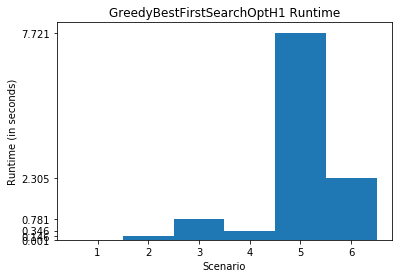

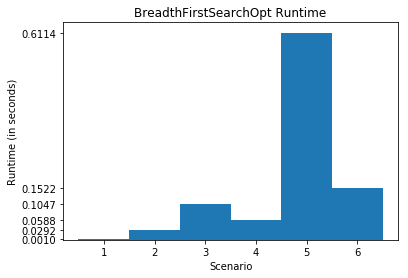

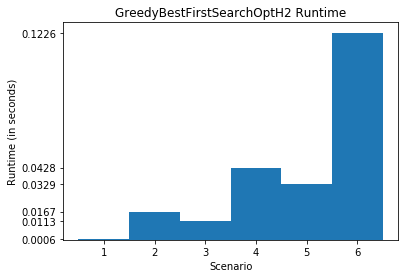

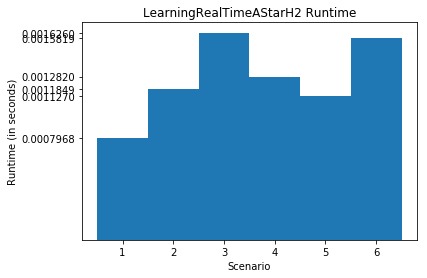

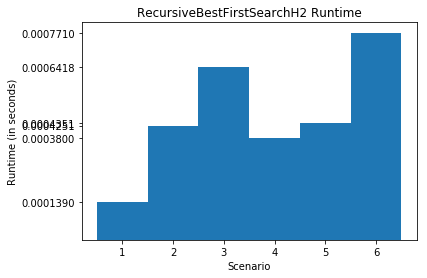

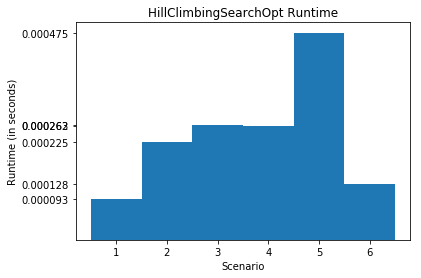

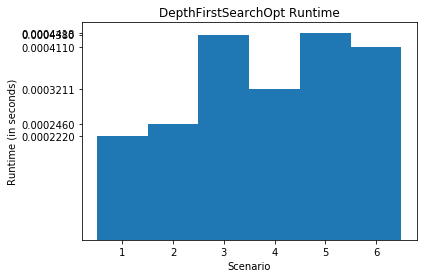

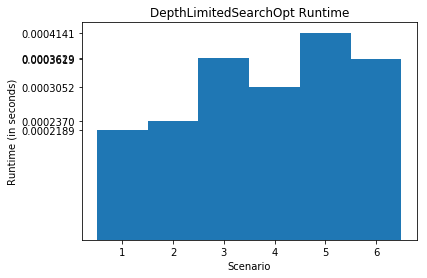

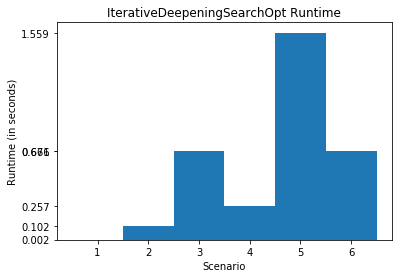

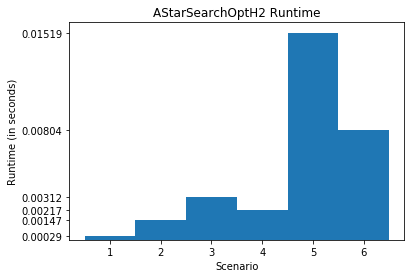

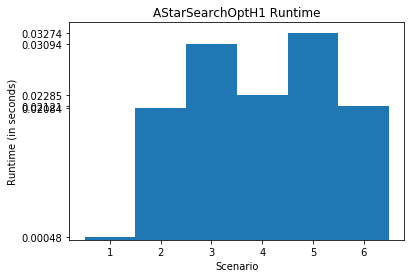

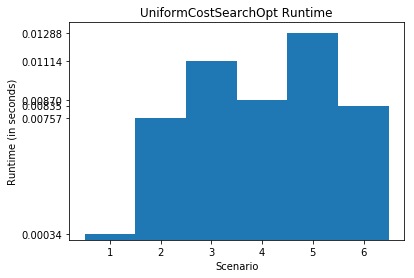

In [450]:
NR_SCENARIO = 0
STRATEGY = 1
RUNTIME = 2
NO_STATES = 3
COST = 4
ACTIONS = 5

PLOTS_PATH = "./Plots/"

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#plot time vs scenario
for tag in results_alg:   
    results_strategy = results_alg[tag]
    top=[(result[NR_SCENARIO], result[RUNTIME]) for result in results_strategy]
    labels, ys = zip(*top)
    xs = np.arange(len(labels)) 
    width = 1
    plt.bar(xs, ys, width, align='center')
    plt.xticks(xs, labels) #Replace default x-ticks with xs, then replace xs with labels
    plt.yticks(ys)
    plt.xlabel('Scenario')
    plt.ylabel('Runtime (in seconds)')
    plt.title(tag + " Runtime")
    plt.savefig(PLOTS_PATH + tag + "Time" + '.png')
    plt.show()

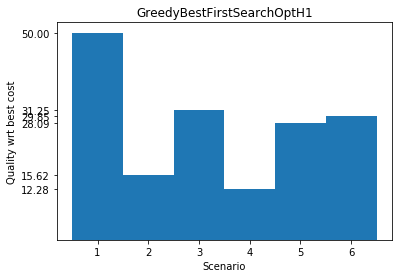

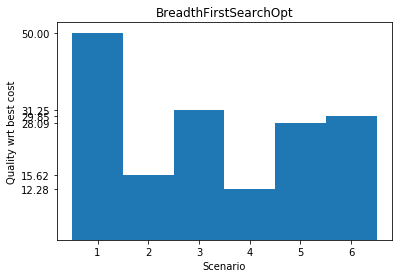

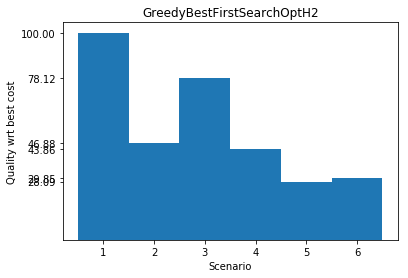

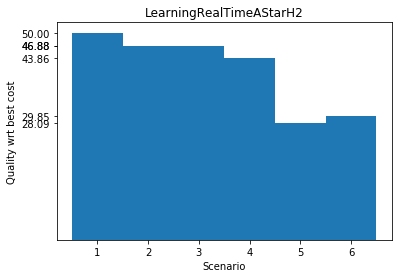

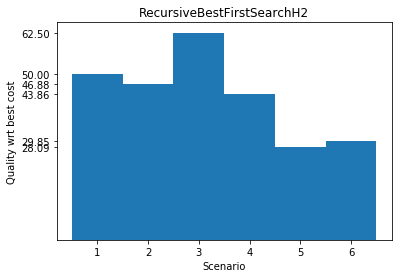

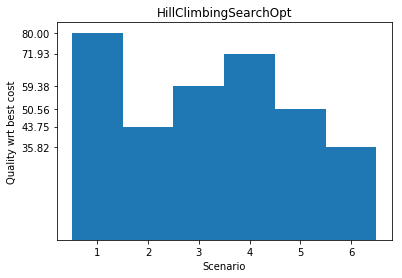

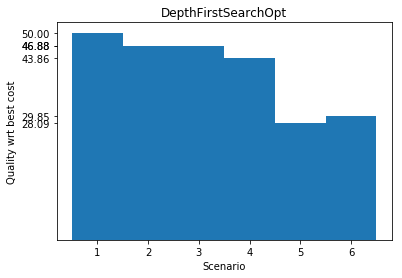

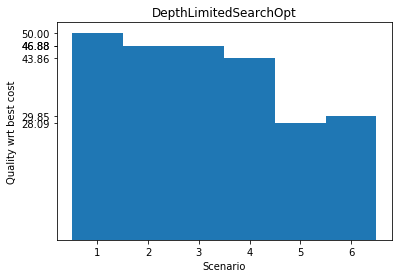

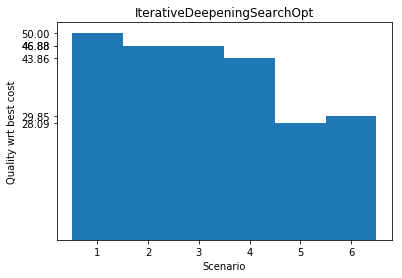

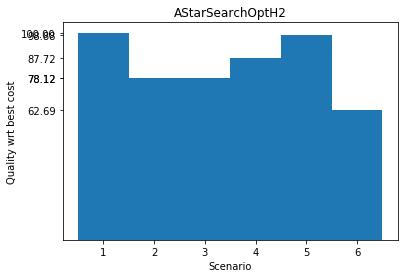

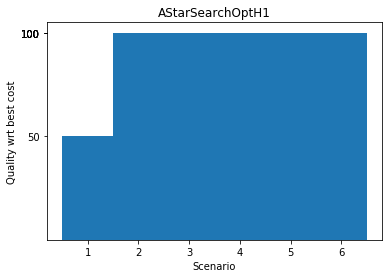

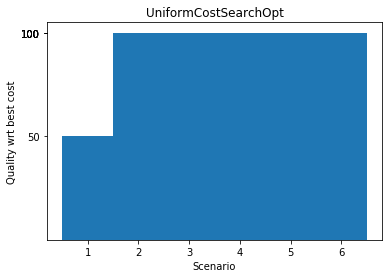

In [451]:

best_cost = [max([results_alg[tag][i][COST] for tag in results_alg]) \
             for i in range(len(os.listdir(INPUT_PATH)))]
#plot quality vs scenario
for tag in results_alg:
    results_strategy = results_alg[tag]
    
    #cat la suta din solutia cea mai buna gasita
    top=[(result[NR_SCENARIO], 1.0 * result[COST] / best_cost[result[NR_SCENARIO] - 1] * 100)\
         for result in results_strategy]
    labels, ys = zip(*top)
    xs = np.arange(len(labels)) 
    width = 1
    plt.bar(xs, ys, width, align='center')
    plt.xticks(xs, labels) #Replace default x-ticks with xs, then replace xs with labels
    plt.yticks(ys)
    plt.xlabel('Scenario')
    plt.ylabel("Quality wrt best cost")
    plt.title(tag)
    plt.savefig(PLOTS_PATH + tag + "Quality" + '.png')
    plt.show()

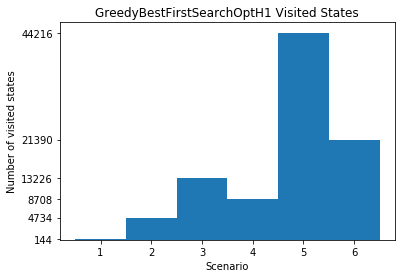

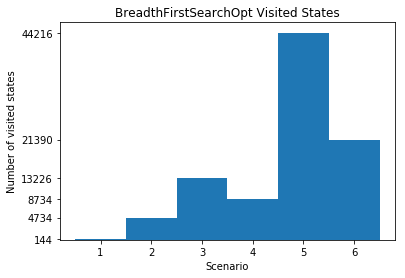

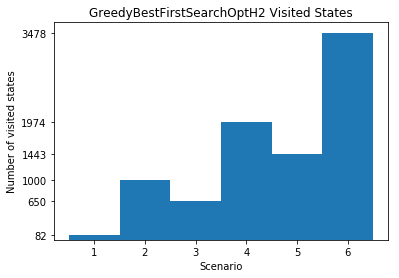

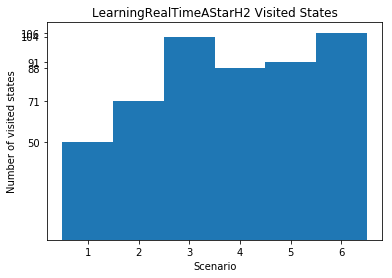

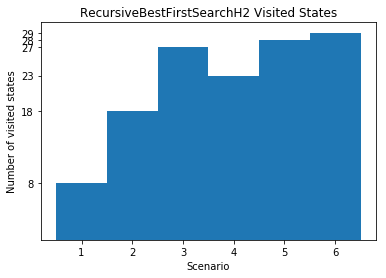

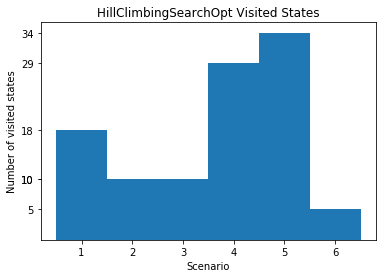

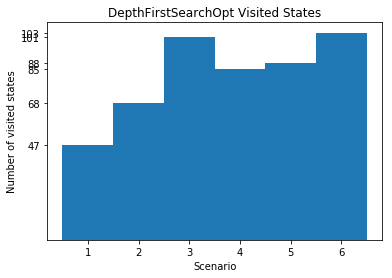

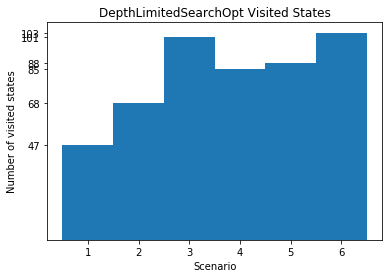

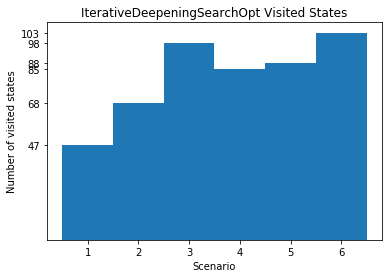

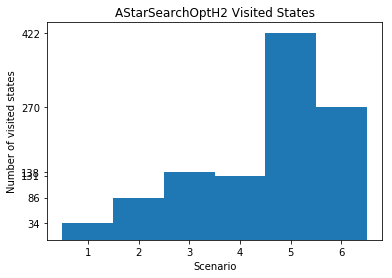

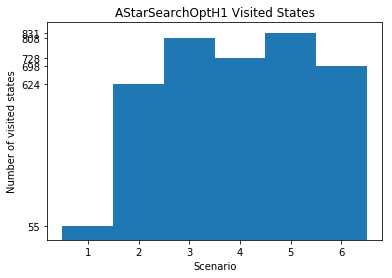

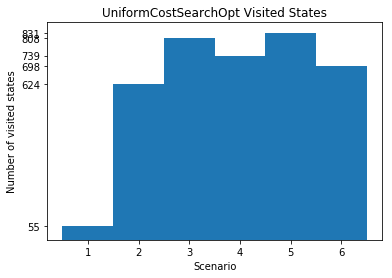

In [452]:
#plot visited nodes vs scenario
for tag in results_alg:   
    results_strategy = results_alg[tag]
    top=[(result[NR_SCENARIO], result[NO_STATES]) for result in results_strategy]
    labels, ys = zip(*top)
    xs = np.arange(len(labels)) 
    width = 1
    plt.bar(xs, ys, width, align='center')
    plt.xticks(xs, labels) #Replace default x-ticks with xs, then replace xs with labels
    plt.yticks(ys)
    plt.xlabel('Scenario')
    plt.ylabel('Number of visited states')
    plt.title(tag + " Visited States")
    plt.savefig(PLOTS_PATH + tag + "Visited" + '.png')
    plt.show()